# Calculating a cost function

Now we look at the method for comparing real patient data with the forward model using the Brain class and other functions we have developed so far. The cost function calculations will form the heart of the MCMC.

Import some necessary modules.

In [1]:
import sys, os
sys.path.append("..")

#SCFC modules
from forward import network_transfer as nt
from utils import path as pth
from utils import functions
from brain import Brain

#generic modules
import matplotlib.pyplot as mpl
import numpy as np
import time
%matplotlib inline
from scipy.signal import decimate

## Importing filtered data

First, let's import some patient data for a single patient. It has been transformed to filtered spectral data as discussed in the notebook 'ChangMEG-data-preprocessing'.

In [2]:
MEG_path = '/Users/Megan/RajLab/MEG-chang' #insert appropriate path here.
directories = pth.walk_tree(MEG_path)
data = 'DK_timecourse_20_filtered.h5'
freqs = 'DK_timecourse_20_filterfreqs.h5'

In [3]:
dir = directories[0]
abspath = os.path.join(MEG_path,dir)
data_path = os.path.join(abspath, data)
FMEGdata = pth.read_hdf5(data_path)
freq_path = os.path.join(abspath, freqs)
f = pth.read_hdf5(freq_path)

Text(0,0.5,'Magnitude (dB)')

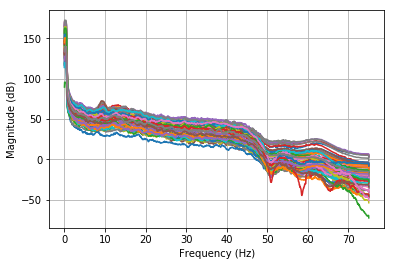

In [4]:
fig = mpl.figure(num=5, figsize = (6,4))
for key in FMEGdata.keys():
    mpl.plot(f,functions.mag2db(FMEGdata[key]))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

In [5]:
FMEGdata.keys()

dict_keys(['LHbankssts', 'LHcaudalanteriorcingulate', 'LHcaudalmiddlefrontal', 'LHcuneus', 'LHentorhinal', 'LHfrontalpole', 'LHfusiform', 'LHinferiorparietal', 'LHinferiortemporal', 'LHinsula', 'LHisthmuscingulate', 'LHlateraloccipital', 'LHlateralorbitofrontal', 'LHlingual', 'LHmedialorbitofrontal', 'LHmiddletemporal', 'LHparacentral', 'LHparahippocampal', 'LHparsopercularis', 'LHparsorbitalis', 'LHparstriangularis', 'LHpericalcarine', 'LHpostcentral', 'LHposteriorcingulate', 'LHprecentral', 'LHprecuneus', 'LHrostralanteriorcingulate', 'LHrostralmiddlefrontal', 'LHsuperiorfrontal', 'LHsuperiorparietal', 'LHsuperiortemporal', 'LHsupramarginal', 'LHtemporalpole', 'LHtransversetemporal', 'RHbankssts', 'RHcaudalanteriorcingulate', 'RHcaudalmiddlefrontal', 'RHcuneus', 'RHentorhinal', 'RHfrontalpole', 'RHfusiform', 'RHinferiorparietal', 'RHinferiortemporal', 'RHinsula', 'RHisthmuscingulate', 'RHlateraloccipital', 'RHlateralorbitofrontal', 'RHlingual', 'RHmedialorbitofrontal', 'RHmiddletempo

## Downsampling

We need to downsample the data to have fewer frequency points. Currently, there are 4488. It would be better to have something close to 150. We can first find the step between adjacent frequencies to figure out roughly how often we should be selecting samples.

### Downsampling using 'decimate'

In [6]:
deltaf = (f[1]-f[0])
print(deltaf)

0.016714954312458213


In [7]:
desired_delta = f[4487]/150
step = desired_delta/deltaf
print(step)

29.913333333333334


This suggests that the best thing to do here is to take every 30 points from the data. In fact, let's try to use the scipy decimate function instead of writing a resampler from scratch. We will also first cut off the very low freqeuncy data to try to mitigate some of the edge effects.

In [8]:
2/deltaf

119.65333333333334

In [9]:
reducef = f[120:]
reducedata = {}
for key in FMEGdata.keys():
    reducedata[key] = FMEGdata[key][120:]

In [10]:
downsampled = decimate(functions.mag2db(reducedata['LHinsula']), 3)
downsampled2 = decimate(downsampled, 10) #suggested you apply it twice in documentation.

/Users/Megan/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3402: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


In [11]:
downf = decimate(reducef, 30)

/Users/Megan/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3402: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


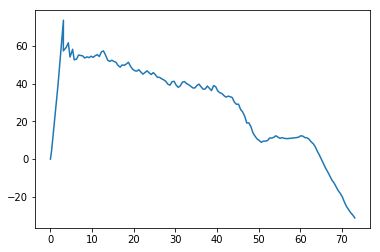

In [12]:
mpl.plot(downf,downsampled2)

(0, 45)

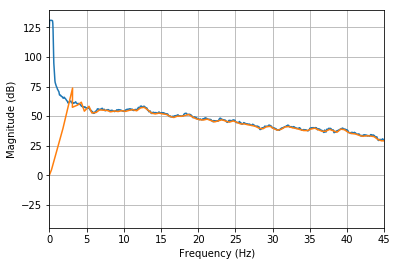

In [13]:
fig2 = mpl.figure(num=5, figsize = (6,4))

mpl.plot(f,functions.mag2db(FMEGdata['LHinsula']))
mpl.plot(downf, downsampled2)

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
mpl.xlim(0,45)

In summary, this doesn't work very well. Although it seems like the 'dumb and simple' thing to do, for now I am going to stick with just choosing a limited number of the data points. 

### Downsampling the 'KISS (Keep It Simple Stupid)' way

For now, I am going to take every thirty of the data points, and the frequency axis. Define a function to do this, where 'n' is the number of points desired.

UPDATE: this function is now included in 'utils/functions.py'

In [14]:
import math
def down_sample(dataarray, n):

    step = math.floor(len(dataarray)/n)

    output = np.empty(n)
    i = 0
    while i < n:
        j = i*step
        output[i] = dataarray[j]
        i += 1
    return output

In [15]:
newf = down_sample(f, 150)
len(newf)

150

Text(0,0.5,'Magnitude (dB)')

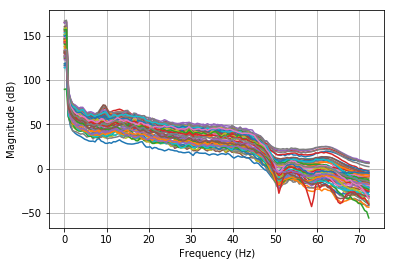

In [16]:
fig3 = mpl.figure(num=5, figsize = (6,4))
downsample = {}
for key in FMEGdata.keys():
    downsample[key] = down_sample(FMEGdata[key], 150)
    mpl.plot(newf,functions.mag2db(downsample[key]))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

Compare the unsampled to the raw data.

Text(0,0.5,'Magnitude (dB)')

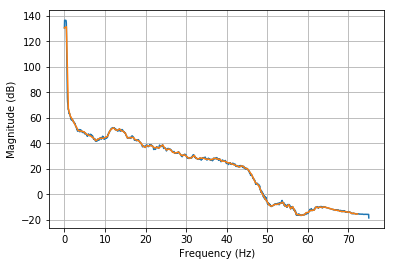

In [17]:
fig4 = mpl.figure(num=5, figsize = (6,4))
mpl.plot(f,functions.mag2db(FMEGdata['LHbankssts']))
mpl.plot(newf,functions.mag2db(downsample['LHbankssts']))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

We only want to work with 2-45Hz data, so we can trim the data before we downsample it (and hopefully improve the capturing of details).

In [18]:
45/deltaf

2692.2

In [19]:
fnew = f[120:2692]
newdata = {}
for key in FMEGdata.keys():
    newdata[key] = FMEGdata[key][120:2692]

Text(0,0.5,'Magnitude (dB)')

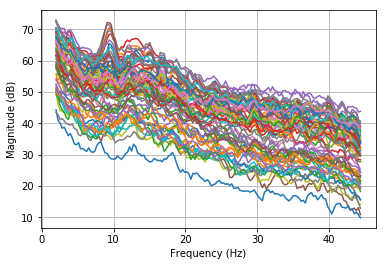

In [20]:
fig5 = mpl.figure(num=5, figsize = (6,4))
downsample = {}
newf = down_sample(fnew, 150)
for key in FMEGdata.keys():
    downsample[key] = down_sample(newdata[key], 150)
    mpl.plot(newf,functions.mag2db(downsample[key]))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

Again, let's compare a region to the undownsampled form.

Text(0,0.5,'Magnitude (dB)')

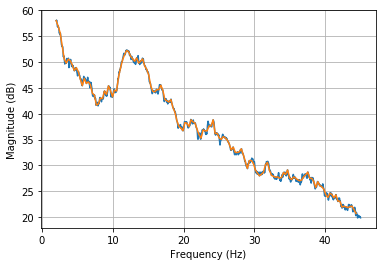

In [21]:
fig6 = mpl.figure(num=5, figsize = (6,4))
mpl.plot(fnew,functions.mag2db(newdata['LHbankssts']))
mpl.plot(newf,functions.mag2db(downsample['LHbankssts']))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

In [22]:
len(downsample['LHbankssts'])

150

In [23]:
len(newdata['LHbankssts'])

2572

This seems to be a reasonable reduction in the number of points in the data.

### Detrending?

Let's try the scipy detrend function and see whether that can assist with our experimental background trend that is not a feature we wish to reproduce with the model.

In [24]:
from scipy.signal import detrend

Text(0,0.5,'Magnitude (dB)')

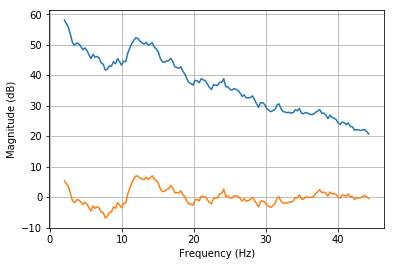

In [25]:
fig6 = mpl.figure(num=5, figsize = (6,4))
data = functions.mag2db(downsample['LHbankssts'])
mpl.plot(newf,data)
mpl.plot(newf,detrend(data))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

OK, this may be useful.

## Setting up brain class instance

Now that we've got that, let's set up a brain class instance to contain the connectivity and distance matrices, corrected as required by the model.

In [26]:
newbrain = Brain.Brain()

In [28]:
hcp_dir = pth.get_sibling_path('data') # connectome information is in /data/ dir
newbrain.add_connectome(hcp_dir) # Use default files in /data/

Remember, we want to reorder the matrices so that they start with the first of the cortex regions and proceed through them in HCP order, before they reach the non-cortical regions.

In [29]:
newbrain.reorder_connectome(newbrain.connectome, newbrain.distance_matrix)

Apply the other matrix reducing and trimming functions.

In [30]:
newbrain.bi_symmetric_c()
newbrain.reduce_extreme_dir()

## Example of forward model calculation

Now, we can do an example of the forward model calculation for the range of frequencies that we found from the filtered data (after they had been downsampled). Use the default parameters that the brain is initialised with.

In [31]:
fq, ev, Vv, freqresp_out, _ = nt.network_transfer_function(newbrain, 
                                                           parameters = newbrain.ntf_params, 
                                                           w=2*np.pi)

In [32]:
newf.shape

(150,)

In [33]:
evec = []
Vvec =[]
fqall = []
freq_model = []

start = time.time()
for freq in newf:
    w = 2*np.pi*freq
    fq, ev, Vv, freqresp_out, _ = nt.network_transfer_function(newbrain, newbrain.ntf_params, w)
    fqall.append(fq)
    evec.append(ev)
    Vvec.append(Vv)
    freq_model.append(freqresp_out)
    
fqall=np.asarray(fqall)
evec = np.asarray(evec)
Vvec = np.asarray(Vvec)
freq_model = np.asarray(freq_model)
freq_model = np.transpose(freq_model)
stop = time.time()
duration = stop - start

print('Computation time = ', duration)

Computation time =  1.3972270488739014


### Plotting output of model

Text(0,0.5,'Magnitude (dB)')

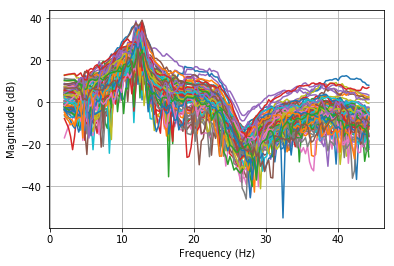

In [34]:
fig = mpl.figure(num=5, figsize = (6,4))
for g in range(len(freq_model)):
    mpl.plot(newf,functions.mag2db(np.abs(freq_model[g,:])))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
#mpl.plot(fvec,mag2db(np.abs(freq_model)))

In [35]:
freq_model.shape

(86, 150)

It is important to remember that the calculation is for more regions than we have data for, and that the order differs. Prior to calculating cost, the data must be reordered.

## Calculating cost using Pearson correlation

### Re-ordering  the MEG data to match the calculations.

The calculations have been performed for 86 regions, cortex first, ordered according to HCP. MEG data is saved in dictionaries (as is the filtered version, and hence the downsampled version) but the calculation is done with matrices that can't have a sensible dictionary form. Therefore, we need to reorder the data.

For this we need the path of the order dictionary (the HCP order) and the function 'order_dict' from 'preprocess/permute.py'

In [36]:
from preprocess import permute
orderfile = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/dictionaries/HCP_list.h5'

Re-ordered the *downsampled* data using this function, and check the ordering against the HCP list.

In [37]:
data = permute.order_dict(downsample, orderfile)

In [38]:
standardlist = pth.read_hdf5(orderfile)

In [39]:
list(data.keys()) == standardlist[:68]

True

### Cost function for a single region

For now, this is following Bobby's cost function calculation, and we look at what we are doign throughout.

In [40]:
lpf = np.array([1, 2, 5, 2, 1])
lpf = lpf/np.sum(lpf)

In [41]:
testdata = data['LHbankssts']

The first step demeans the data.

Text(0,0.5,'Magnitude (dB)')

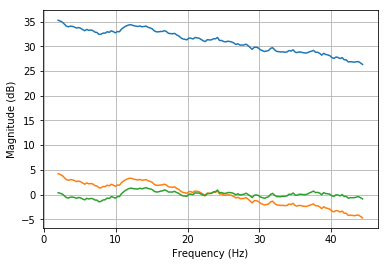

In [46]:
fig7 = mpl.figure(num=5, figsize = (6,4))
testdata = functions.mag2db(testdata)
testdata2 = testdata - np.mean(testdata)
testdata3 = detrend(testdata)
mpl.plot(newf,testdata)
mpl.plot(newf,testdata2)
mpl.plot(newf,testdata3) #using the detrend function for comparison

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

It looks like the detrend function is very useful here.

Text(0,0.5,'Magnitude (dB)')

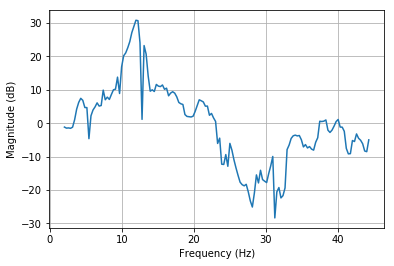

In [47]:
fig8 = mpl.figure(num=5, figsize = (6,4))
mpl.plot(newf,functions.mag2db(freq_model[0,:]))
mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

In the analysis performed so far, this is also de-meaned.

In [48]:
qmodel = functions.mag2db(freq_model[0,:])
qmodel = qmodel - np.mean(qmodel)

Text(0,0.5,'Magnitude (dB)')

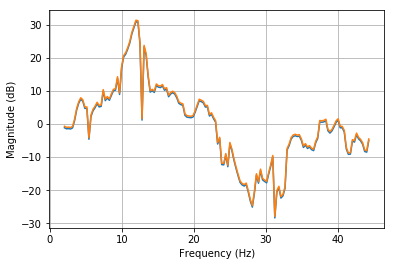

In [49]:
fig9 = mpl.figure(num=5, figsize = (6,4))
mpl.plot(newf,functions.mag2db(freq_model[0,:]))
mpl.plot(newf,qmodel)
mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

Which in this case makes very little difference. We can now take the step of applying the pearson r correlation calculation to this particular region just to check it works. 


In [55]:
testdata3 = [float(x) for x in testdata3] #need to recast to correct sort of float, apparently.
qmodel = [float(x) for x in qmodel]

In [65]:
from scipy.stats import pearsonr
err_min = pearsonr(testdata3, qmodel)

In [66]:
err_min

(0.26966421440577537, 0.0008465385531490662)

By itself this isn't a suitable error calculation, because Pearson's correlation *increases* as the data match. So, it is better to take -1(correlation coefficient) and add 1, so that perfect correlation is zero.

In Bobby's functions, the model data is convolved with a low pass filter prior to putting in dB, de-meaning and taking the correlation. So let's try that for comparison.

In [53]:
qmodel2 = functions.mag2db(np.convolve(freq_model[0,:],lpf, mode='same'))
qmodel2 = qmodel2 - np.mean(qmodel2)

Text(0,0.5,'Magnitude (dB)')

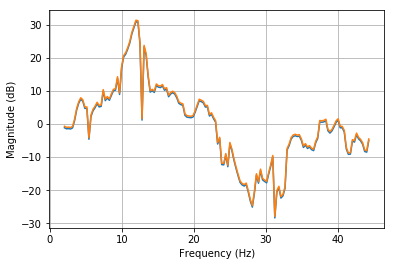

In [54]:
fig10 = mpl.figure(num=5, figsize = (6,4))
mpl.plot(newf,functions.mag2db(freq_model[0,:]))
mpl.plot(newf,qmodel)
mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

Hmmm. Can't see much difference -- need to check with Bobby how exactly he intended this to be applied.

Just to look at how this is working and get an intuition for it, I will directly plot data against model, to show the origin of the Pearson r coeffiecient.

Text(0,0.5,'data values')

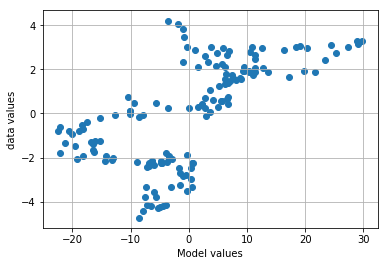

In [61]:
fig11 = mpl.figure(num=5, figsize = (6,4))
mpl.scatter(qmodel2, testdata2)
mpl.grid(True)
mpl.xlabel('Model values')
mpl.ylabel('data values')

Were all these points to lie on a straight line (implying a fit up to a constant magnitude and offset) then the correlation coefficient would be 1.

Let's just plot the data and model together to see a more traditional way to calculate error.

Text(0,0.5,'Magnitude (dB)')

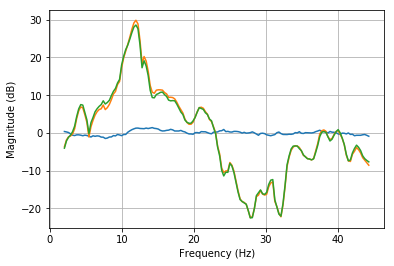

In [80]:
error = qmodel2 - detrend(testdata2)

fig12 = mpl.figure(num=5, figsize = (6,4))
mpl.plot(newf, detrend(testdata2))
mpl.plot(newf, qmodel2)
mpl.plot(newf, error)
mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

OK, obviously because the model and data are on hugely different scales, this isn't terribly useful, which is the reason for using Pearson r in the first place. However, let's find a scaling factor with this piece of data by matching the maxima.

In [76]:
a = max(detrend(testdata2))

In [77]:
b = max(np.real(qmodel2))

In [78]:
scale = a/b

In [79]:
scaledmodel = scale*qmodel2

Text(0,0.5,'Magnitude (dB)')

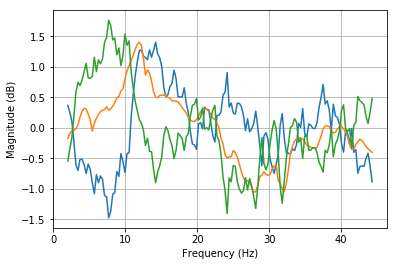

In [82]:
error = scaledmodel - detrend(testdata2)
fig13 = mpl.figure(num=5, figsize = (6,4))
mpl.plot(newf, detrend(testdata2))
mpl.plot(newf, scaledmodel)
mpl.plot(newf, error)
mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

OK, maybe this isn't the right thing to do. Maybe for now we keep it simple with the correlation coefficient.

## Bringing this in to MCMC

I have covered the general use of the emcee package in another notebook, 'MCMCHammer Example' which is available on the group's gitlab repository. 

Following that, the first question we have to ask is: 'what is the best way to write the likelihood function?' From this, everything else follows. This will be placed in the next notebook in the series. 